# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 4.1 Multi Agent DDPG

#### Load Libraries
Load the necessary libraries

In [5]:
from maddpg_singlenet_agents import Agent as MADDPG_agents
from maddpg_agent import Agent as MADDPG_agent
from buffer import ReplayBuffer
from ddpg_agents import Agent as DDPG_agents
from collections import deque
import torch
import matplotlib.pyplot as plt

#### Player Function
Function to run the environments and the agents over episodic tasks

In [6]:
def maddpg_singlenet_run(n_episodes=1000, max_t=1000, print_every=100):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    agents = MADDPG_agents(state_size=state_size, action_size=action_size, n_agents = num_agents, random_seed=1)
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agents.reset()                                         # reset exploration
        for t in range(max_t):
            actions= agents.act(states)                        # run the agents
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agents.step(states, actions, rewards, next_states, dones) # add to memory
            agents.learn()                                     # learn for both agents
            states = next_states
            scores += rewards                                  # update the score (for each agent)

            if np.any(dones):                                  # exit loop if episode finished
                break
            
        score = np.max(scores)
        scores_deque.append(score)
        scores_list.append(score)
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor_maddpg_singlenet.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic_maddpg_singlenet.pth')
            break
            
    return scores_list

In [6]:
def maddpg_run(n_episodes=1000, max_t=1000, print_every=100):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    BUFFER_SIZE = int(1e5)  # replay buffer size
    BATCH_SIZE = 256        # minibatch size
    
    # Replay memory
    memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 1)
    agents = []
    for i in range(num_agents):
        agents.append(MADDPG_agent(state_size=state_size, action_size=action_size,n_agents = num_agents, random_seed=1))
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        for i in range(num_agents):
            agents[i].reset()                                          # reset exploration
        for t in range(max_t):
            actions = np.zeros((num_agents,action_size))
            for i in range(num_agents):
                actions[i] = agents[i].act(states[i])          # run the agents
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            memory.add(states, actions, rewards, next_states, dones) # add to memory
            if len(memory) > BATCH_SIZE:
                experiences = memory.sample()
                states_buffer, _, _, next_states_buffer, _ = experiences
                #next and predicted actions
                actions_next = torch.from_numpy(np.zeros((BATCH_SIZE, action_size*num_agents))).float().to(device) #initialize actions to 0
                actions_pred = torch.from_numpy(np.zeros((BATCH_SIZE, action_size*num_agents))).float().to(device) #initialize actions to 0
                for i in range(num_agents):
                    actions_next[:,i*action_size:(i+1)*action_size] = agents[i].actor_target(next_states_buffer[i::num_agents,:]).cpu().data
                    actions_pred[:,i*action_size:(i+1)*action_size] = agents[i].actor_local(states_buffer[i::num_agents,:]).cpu().data
                
                agent_id = t%num_agents                        # alternate learning on agents
                agents[agent_id].learn(agent_id,experiences,actions_next,actions_pred) # learn for the selected agent
            states = next_states
            scores += rewards                                  # update the score (for each agent)

            if np.any(dones):                                  # exit loop if episode finished
                break
            
        score = np.max(scores)
        scores_deque.append(score)
        scores_list.append(score)
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor_maddpg.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic_maddpg.pth')
            break
            
    return scores_list

In [7]:
def ddpg_run(n_episodes=1000, max_t=1000, print_every=100):
    agents = DDPG_agents(state_size=state_size, action_size=action_size, n_agents = num_agents, random_seed=1)
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agents.reset()                                         # reset exploration
        for t in range(max_t):
            actions= agents.act(states)                        # run the agents
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agents.step(states, actions, rewards, next_states, dones) # add to memory
            agents.learn()
            states = next_states
            scores += rewards                                  # update the score (for each agent)

            if np.any(dones):                                  # exit loop if episode finished
                break
            
        score = np.max(scores)
        scores_deque.append(score)
        scores_list.append(score)
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor_ddpg.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic_ddpg.pth')
            break
            
    return scores_list

#### Run Function
Executing training and reporting results

In [7]:
scores_list = maddpg_singlenet_run()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_list)+1), scores_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.006
Episode 200	Average Score: 0.008
Episode 300	Average Score: 0.008
Episode 400	Average Score: 0.005
Episode 500	Average Score: 0.006
Episode 600	Average Score: 0.010
Episode 700	Average Score: 0.009
Episode 800	Average Score: 0.004


KeyboardInterrupt: 

In [7]:
scores_list = maddpg_run()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_list)+1), scores_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.007
Episode 200	Average Score: 0.005
Episode 300	Average Score: 0.008
Episode 400	Average Score: 0.005
Episode 448	Average Score: 0.002

KeyboardInterrupt: 

Episode 100	Average Score: 0.005
Episode 200	Average Score: 0.003
Episode 300	Average Score: 0.036
Episode 400	Average Score: 0.095
Episode 500	Average Score: 0.351
Episode 600	Average Score: 0.386
Episode 700	Average Score: 0.379
Episode 800	Average Score: 0.458
Episode 819	Average Score: 0.503
Environment solved in 819 episodes!	Average Score: 0.503


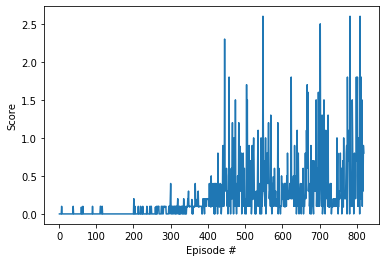

In [7]:
scores_list = ddpg_run()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_list)+1), scores_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()